In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import deepdish.io as dd
from sklearn.preprocessing import normalize, robust_scale, scale
import os
from utils.Row_Data_Processing import ProcessedData, ProcessedAndInterpolatedData

import torch
from IPython.core.debugger import set_trace

In [2]:
path = os.getcwd()
main_folder_path = path#path.replace(path.split('/')[-1],'')
path = main_folder_path + "Data_npy/Chosen ones/"

In [3]:
class LoadLargeData:
    def __init__(self, name, name_path=False, verbose=True):
        if not name_path:
            self.names = np.load(main_folder_path + "/{}".format(name)).tolist()
        else:
            self.names = np.load(name_path + name).tolist()
        self.number_of_shots = len(self.names)
        if verbose:
            print("Number of shots: {}".format(self.number_of_shots))
            for i, j in enumerate(self.names):
                print("{} of {}: {}".format(i+1, self.number_of_shots, j))

    def load(self, shot_index, return_df = False):
        if shot_index >= self.number_of_shots:
            raise IndexError("Shot index out of bounds")
        output = dd.load(self.names[shot_index])
        if return_df:
            return output.dataframe
        else:
            return output

In [4]:
def prepare_sequences(lld, length=160, downsample=10):
    h_alpha_sequences, label_sequences, h_alphas, labels = [],[],[],[]
    length = int(length)
    for i in range(lld.number_of_shots):
        tmp = lld.load(i)
        h_alphas.append(tmp.dataframe.H_alpha.values[::downsample])
        labels.append(tmp.labels[::downsample])
    # prepare sequences
    step = int(100/downsample) # original downsampling rate was 100 => getting same points as in previous experiment
    for x,lab in zip(h_alphas,labels):
        size = len(x)
        h_alpha_sequences.append(torch.tensor([x[i:i+length] for i in range(0, size-(length-step+1), step)]))
        label_sequences.append(torch.tensor([lab[i+int(length/2)] for i in range(0, size-(length-step+1), step)]))
    # setting labels to center points of sequences
    #set_trace()
    return torch.cat(tuple(h_alpha_sequences),axis=0), torch.cat(tuple(label_sequences), axis=0)


In [5]:
data_path = "/Users/Ghosty/Desktop/Processed Data/PAID/"

LLD = LoadLargeData(name="new_dataset.npy", name_path=False, verbose=True)

Number of shots: 20
1 of 20: /Users/Ghosty/Desktop/Processed Data/PAID/shot_10211.h5
2 of 20: /Users/Ghosty/Desktop/Processed Data/PAID/shot_9372.h5
3 of 20: /Users/Ghosty/Desktop/Processed Data/PAID/shot_9312.h5
4 of 20: /Users/Ghosty/Desktop/Processed Data/PAID/shot_13511.h5
5 of 20: /Users/Ghosty/Desktop/Processed Data/PAID/shot_9738.h5
6 of 20: /Users/Ghosty/Desktop/Processed Data/PAID/shot_9735.h5
7 of 20: /Users/Ghosty/Desktop/Processed Data/PAID/shot_7072.h5
8 of 20: /Users/Ghosty/Desktop/Processed Data/PAID/shot_9748.h5
9 of 20: /Users/Ghosty/Desktop/Processed Data/PAID/shot_16934.h5
10 of 20: /Users/Ghosty/Desktop/Processed Data/PAID/shot_16935.h5
11 of 20: /Users/Ghosty/Desktop/Processed Data/PAID/shot_18164.h5
12 of 20: /Users/Ghosty/Desktop/Processed Data/PAID/shot_10105.h5
13 of 20: /Users/Ghosty/Desktop/Processed Data/PAID/shot_10226.h5
14 of 20: /Users/Ghosty/Desktop/Processed Data/PAID/shot_9751.h5
15 of 20: /Users/Ghosty/Desktop/Processed Data/PAID/shot_9376.h5
16 of 2

In [6]:
tmp = LLD.load(0)

/Users/Ghosty/miniconda3/envs/Pytorch/lib/python3.7/site-packages/deepdish/io/hdf5io.py:655: UserWarning: This file was saved with a newer version of deepdish. Please upgrade to make sure it loads correctly.
  warnings.warn('This file was saved with a newer version of '


In [31]:
len(tmp.dataframe.time/1000)/(max(tmp.dataframe.time/1000)-min(tmp.dataframe.time/1000))

2000006.024096385

In [37]:
np.sum(np.array([len(LLD.load(i).dataframe.time) for i in range(20)]))

8398020

In [65]:
tmp.dataframe.time[::10]

0          985.000
10         985.005
20         985.010
30         985.015
40         985.020
            ...   
331960    1150.980
331970    1150.985
331980    1150.990
331990    1150.995
332000    1151.000
Name: time, Length: 33201, dtype: float64

In [194]:
tmp_time=tmp.dataframe.time[::10].values
tmp_h=tmp.dataframe.H_alpha[::10].values

In [195]:
tmp_time = tmp_time[15000:15500]
tmp_h = tmp_h[15000:15500]

In [196]:
indexy = [tmp_time[i:i+160] for i in range(0, len(tmp_time)-(160-10+1), 10)]

In [197]:
len(np.min(indexy, axis=1))

35

In [198]:
print(np.min(indexy, axis=1)[0])
print(np.max(indexy, axis=1)[0])

1060.0
1060.795


In [199]:
(tmp_time[1]-tmp_time[0])*160

0.8000000000174623

In [200]:
def get_colors(inp, colormap, vmin=0, vmax=20):
    norm = plt.Normalize(vmin, vmax)
    return colormap(norm(inp))

In [201]:
len(np.max(indexy, axis=1))

35

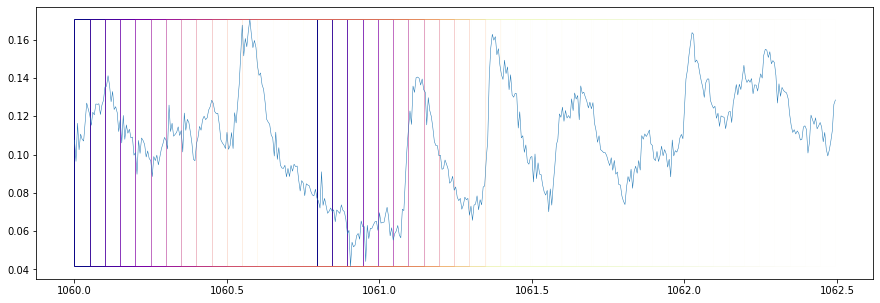

In [255]:
fig, ax = plt.subplots(1, figsize=(15,5))
ax.plot(tmp_time, tmp_h, lw=0.5)
for i,(st,en) in enumerate(zip(np.min(indexy,axis=1), np.max(indexy,axis=1))):
    ax.add_patch(
        Rectangle(
            (st, min(tmp_h)), 
            width=(en-st), 
            height=max(tmp_h)-min(tmp_h), 
            color=get_colors(i,plt.cm.plasma, 0, 15), 
            alpha=max(0.3/(i+1),(13-i)/13), 
            fill=False))

#ax.scatter(np.max(indexy,axis=1)[7:], 0.1*np.ones_like(np.max(indexy,axis=1)[7:]), c=[get_colors(i, plt.cm.plasma, 0, len(np.max(indexy,axis=1)[7:])) for i in range(len(np.max(indexy,axis=1)[7:]))], lw=0.01)

plt.show()

In [9]:
X, y = prepare_sequences(lld=LLD, length=160, downsample=10)

In [16]:
#np.save("sequenced_data_for_VAE_lenght-160_stride-10.npy", X)
#np.save("sequenced_data_for_VAE_lenght-160_stride-10_targets.npy", y)

In [15]:
#dd.save("sequenced_data_for_VAE_lenght-160_stride-10.h5", {"X": X, "y": y})

In [17]:
LLD.load(1).labels

array([1., 1., 1., ..., 0., 0., 0.])

In [19]:
t, tl = LLD.load(0).dataframe.H_alpha, LLD.load(0).labels

/Users/Ghosty/miniconda3/envs/Pytorch/lib/python3.7/site-packages/deepdish/io/hdf5io.py:655: UserWarning: This file was saved with a newer version of deepdish. Please upgrade to make sure it loads correctly.
  warnings.warn('This file was saved with a newer version of '


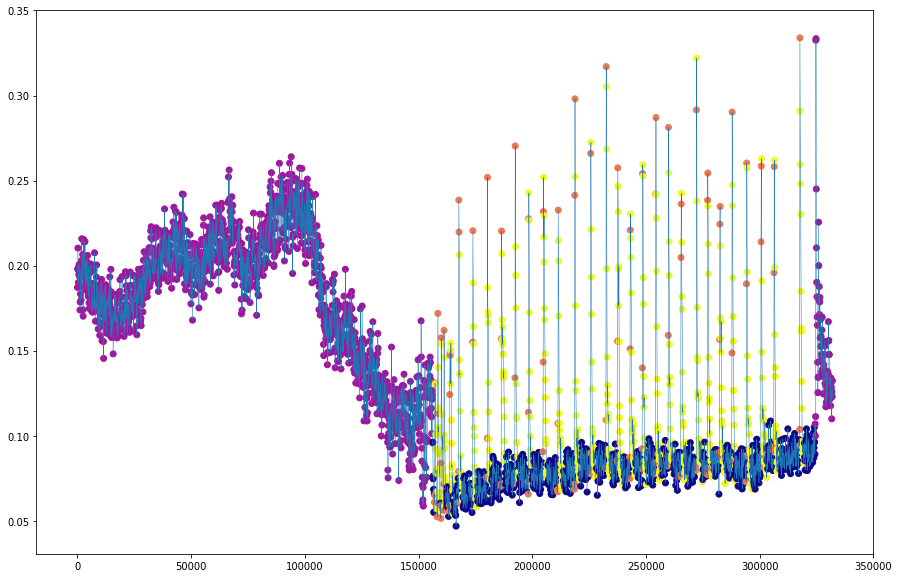

In [36]:
plt.figure(figsize=(15,10))
plt.plot(t.index[::100], t.values[::100],lw=0.5)
plt.scatter(t.index[::100], t.values[::100], c=tl[::100], cmap=plt.cm.plasma)
plt.show()

In [41]:
tt = torch.tensor([t.values[i:i+16] for i in range(0, len(t.values)-9, 8)])

In [42]:
tt

tensor([[0.1872, 0.1958, 0.1897,  ..., 0.1876, 0.1829, 0.1820],
        [0.1906, 0.1977, 0.1890,  ..., 0.1877, 0.1802, 0.1797],
        [0.1815, 0.1857, 0.1805,  ..., 0.1966, 0.1904, 0.1882],
        ...,
        [0.1226, 0.1285, 0.1181,  ..., 0.1233, 0.1236, 0.1291],
        [0.1273, 0.1317, 0.1280,  ..., 0.1333, 0.1272, 0.1281],
        [0.1329, 0.1365, 0.1288,  ..., 0.1344, 0.1326, 0.1335]],
       dtype=torch.float64)

In [79]:
ttt = np.array(tt)
ttt = robust_scale(ttt, axis=0)

In [80]:
tt

tensor([[0.1872, 0.1958, 0.1897,  ..., 0.1876, 0.1829, 0.1820],
        [0.1906, 0.1977, 0.1890,  ..., 0.1877, 0.1802, 0.1797],
        [0.1815, 0.1857, 0.1805,  ..., 0.1966, 0.1904, 0.1882],
        ...,
        [0.1226, 0.1285, 0.1181,  ..., 0.1233, 0.1236, 0.1291],
        [0.1273, 0.1317, 0.1280,  ..., 0.1333, 0.1272, 0.1281],
        [0.1329, 0.1365, 0.1288,  ..., 0.1344, 0.1326, 0.1335]],
       dtype=torch.float64)

In [81]:
ttt

array([[ 0.60531991,  0.62752161,  0.64367816, ...,  0.55100575,
         0.58129496,  0.58992806],
       [ 0.63623293,  0.64481268,  0.63649425, ...,  0.55172414,
         0.55683453,  0.56834532],
       [ 0.55283968,  0.53530259,  0.55890805, ...,  0.6329023 ,
         0.64964029,  0.64604317],
       ...,
       [ 0.01437815,  0.01080692, -0.01149425, ..., -0.03663793,
         0.03884892,  0.10503597],
       [ 0.05751258,  0.03962536,  0.07902299, ...,  0.0545977 ,
         0.07122302,  0.09640288],
       [ 0.108555  ,  0.08357349,  0.0862069 , ...,  0.06465517,
         0.12086331,  0.14604317]])

In [82]:
tmp = np.array([i[8:16] for i in ttt])
tmp = np.concatenate(tmp)
tmp

array([0.63623293, 0.64481268, 0.63649425, ..., 0.06465517, 0.12086331,
       0.14604317])

In [83]:
len(tmp)

331992

In [84]:
len(t)-8

331993

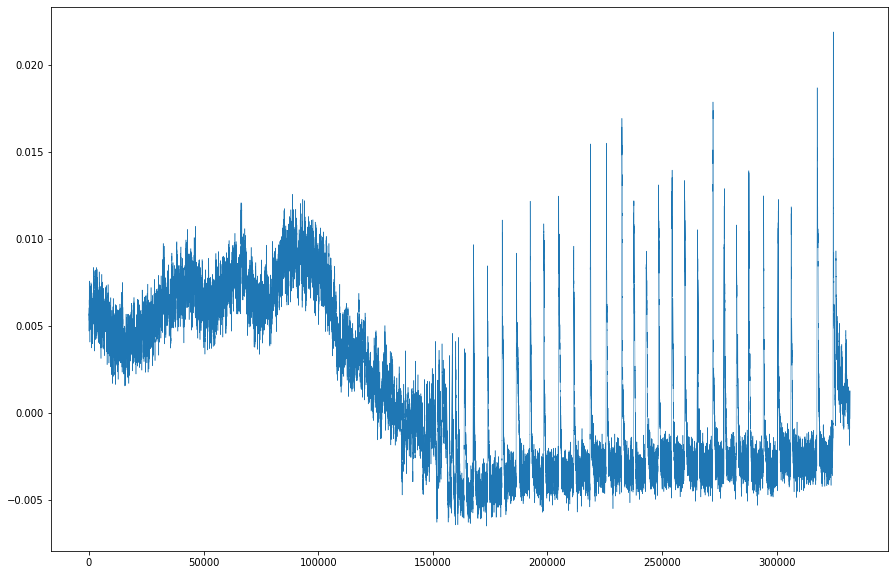

In [86]:
norm_scale = np.concatenate(np.array([i[8:16] for i in normalize(ttt,axis=0)]))
ax = np.arange(len(norm_scale))
plt.figure(figsize=(15,10))
plt.plot(ax, norm_scale,lw=0.5)
#plt.scatter(t.index[::100], t.values[::100], c=tl[::100], cmap=plt.cm.plasma)
plt.show()

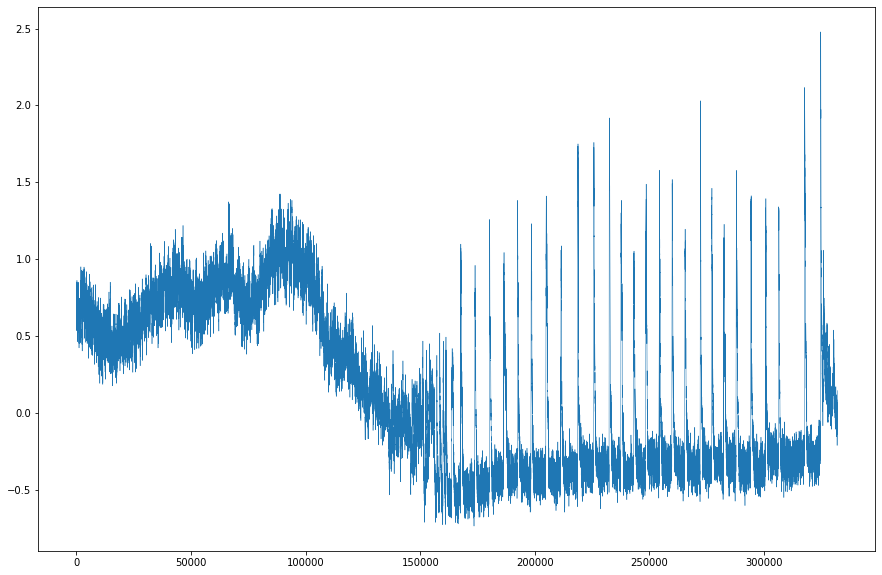

In [87]:
robus_scale = np.concatenate(np.array([i[8:16] for i in robust_scale(ttt,axis=0)]))
ax = np.arange(len(robus_scale))
plt.figure(figsize=(15,10))
plt.plot(ax, robus_scale,lw=0.5)
#plt.scatter(t.index[::100], t.values[::100], c=tl[::100], cmap=plt.cm.plasma)
plt.show()

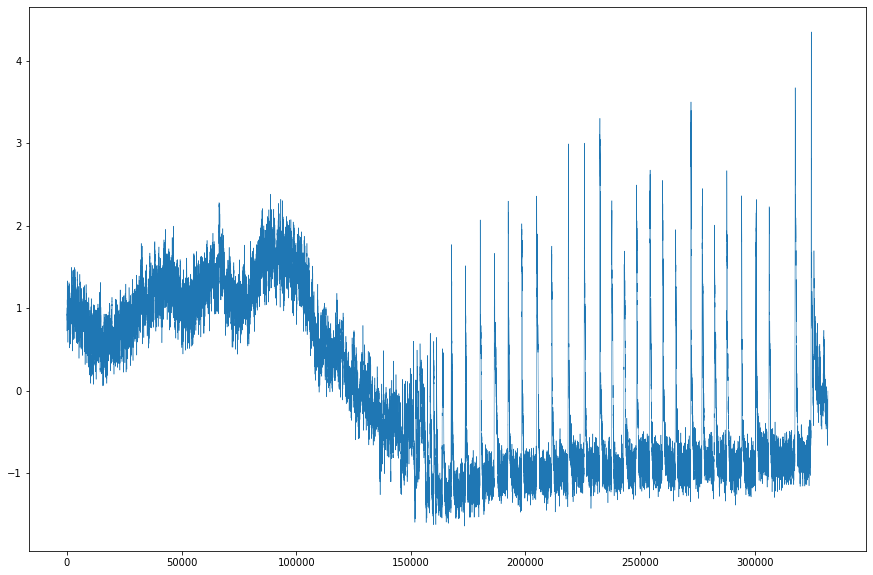

In [88]:
scale_scale = np.concatenate(np.array([i[8:16] for i in scale(ttt,axis=0)]))
ax = np.arange(len(scale_scale))
plt.figure(figsize=(15,10))
plt.plot(ax, scale_scale,lw=0.5)
#plt.scatter(t.index[::100], t.values[::100], c=tl[::100], cmap=plt.cm.plasma)
plt.show()

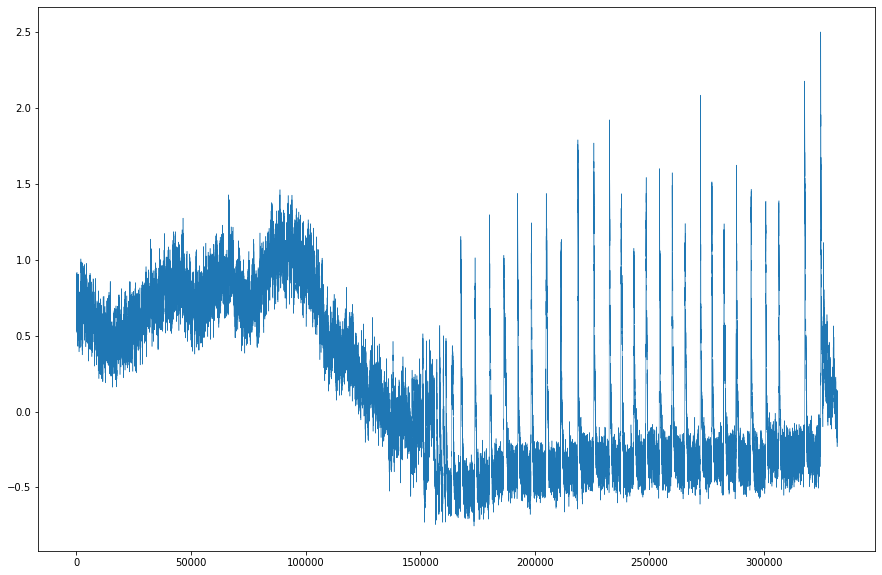

In [97]:
robust_scale_t = robust_scale(t.values)
ax = np.arange(len(robust_scale_t))
plt.figure(figsize=(15,10))
plt.plot(ax, robust_scale_t,lw=0.5)
#plt.scatter(t.index[::100], t.values[::100], c=tl[::100], cmap=plt.cm.plasma)
plt.show()

In [93]:
t.values[::100]

array([0.18723264, 0.19800127, 0.21034196, ..., 0.1258436 , 0.12301389,
       0.13236766])

In [101]:
def norm(x):
    return x/np.mean(x[:300])

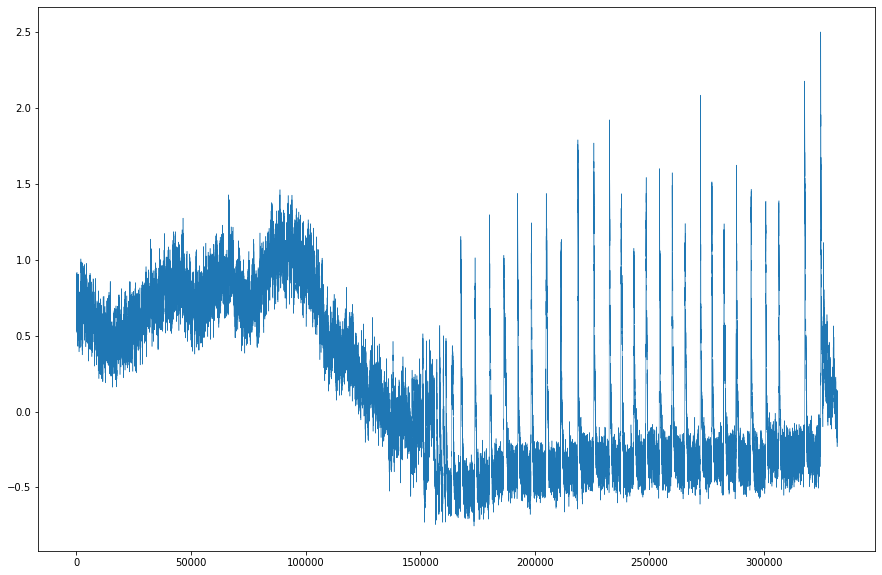

In [103]:
robust_scale_t = robust_scale(norm(t.values))
ax = np.arange(len(robust_scale_t))
plt.figure(figsize=(15,10))
plt.plot(ax, robust_scale_t,lw=0.5)
#plt.scatter(t.index[::100], t.values[::100], c=tl[::100], cmap=plt.cm.plasma)
plt.show()

In [104]:
t2, tl2 = LLD.load(1).dataframe.H_alpha, LLD.load(1).labels

/Users/Ghosty/miniconda3/envs/Pytorch/lib/python3.7/site-packages/deepdish/io/hdf5io.py:655: UserWarning: This file was saved with a newer version of deepdish. Please upgrade to make sure it loads correctly.
  warnings.warn('This file was saved with a newer version of '


In [113]:
t3, tl3 = LLD.load(2).dataframe.H_alpha, LLD.load(2).labels

/Users/Ghosty/miniconda3/envs/Pytorch/lib/python3.7/site-packages/deepdish/io/hdf5io.py:655: UserWarning: This file was saved with a newer version of deepdish. Please upgrade to make sure it loads correctly.
  warnings.warn('This file was saved with a newer version of '


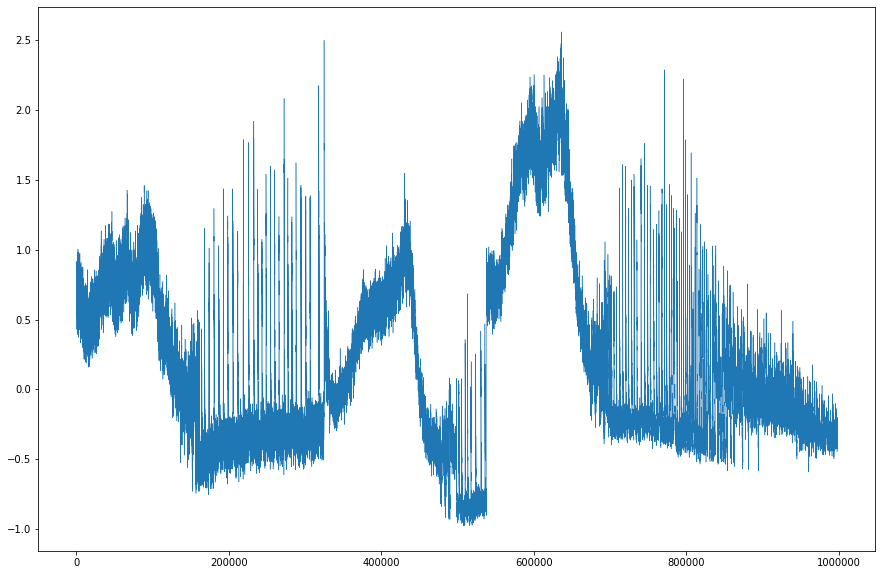

In [114]:
robust_scale_t = robust_scale(t.values)
robust_scale_t2 = robust_scale(t2.values)
robust_scale_t3 = robust_scale(t3.values)
robust_scale_t = np.concatenate([robust_scale_t, robust_scale_t2,robust_scale_t3])
ax = np.arange(len(robust_scale_t))
plt.figure(figsize=(15,10))
plt.plot(ax, robust_scale_t,lw=0.5)
#plt.scatter(t.index[::100], t.values[::100], c=tl[::100], cmap=plt.cm.plasma)
plt.show()

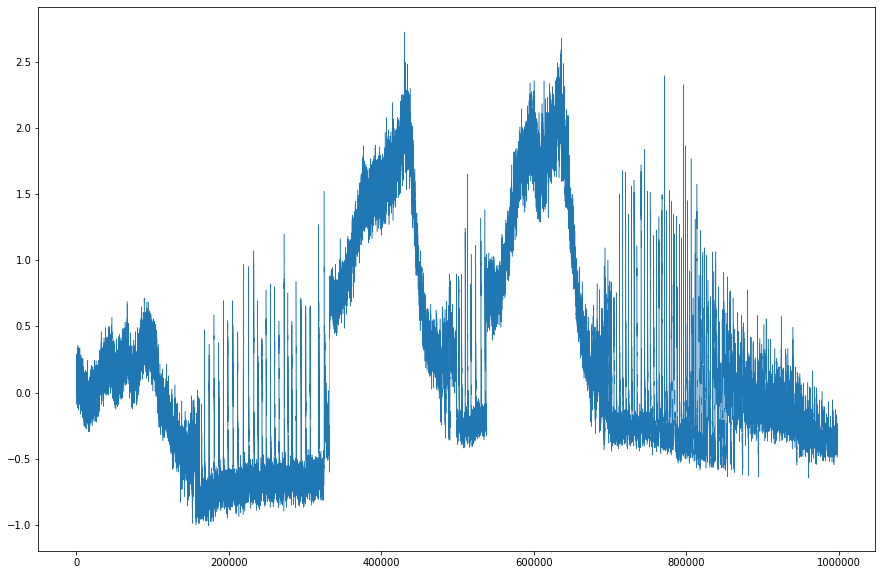

In [115]:
robust_scale_t = robust_scale(np.concatenate([t.values, t2.values, t3.values]))
ax = np.arange(len(robust_scale_t))
plt.figure(figsize=(15,10))
plt.plot(ax, robust_scale_t,lw=0.5)
#plt.scatter(t.index[::100], t.values[::100], c=tl[::100], cmap=plt.cm.plasma)
plt.show()

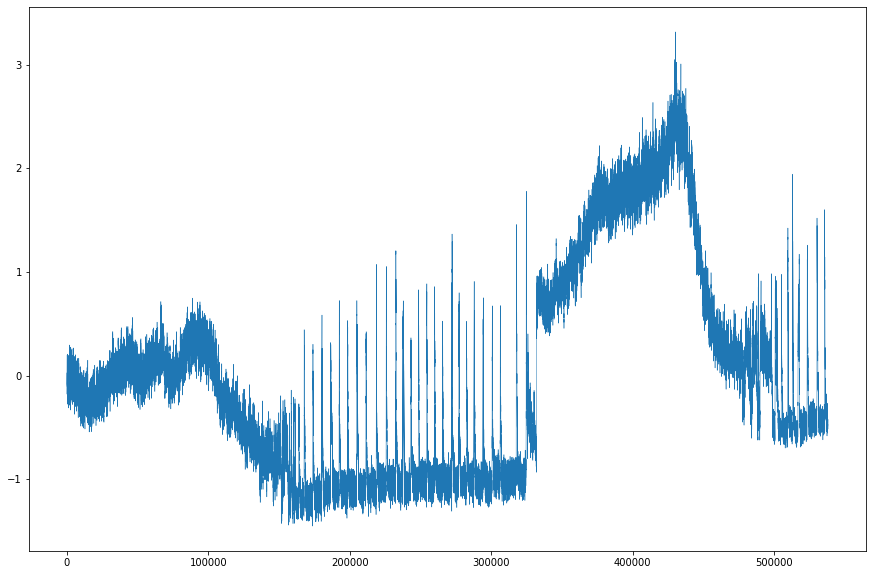

In [111]:
robust_scale_t = scale(np.concatenate([t.values, t2.values]))
ax = np.arange(len(robust_scale_t))
plt.figure(figsize=(15,10))
plt.plot(ax, robust_scale_t,lw=0.5)
#plt.scatter(t.index[::100], t.values[::100], c=tl[::100], cmap=plt.cm.plasma)
plt.show()

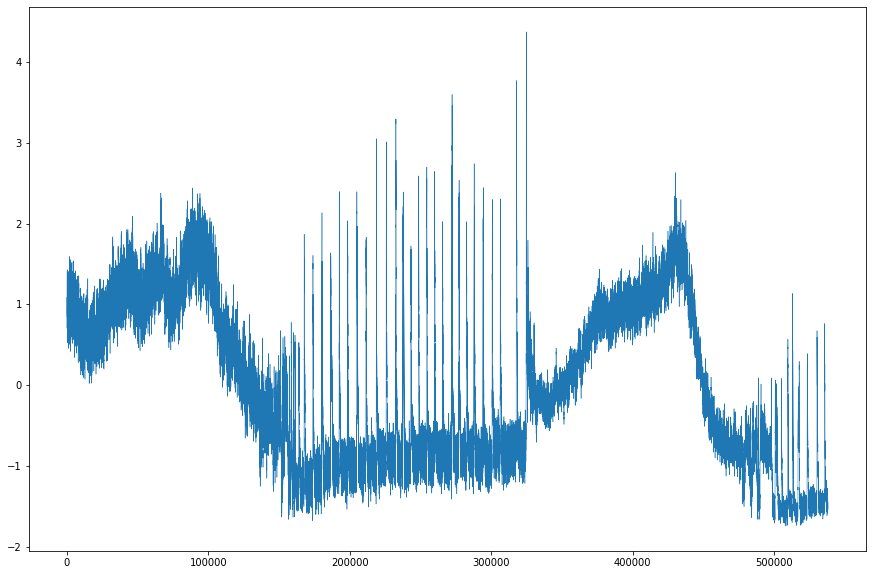

In [112]:
robust_scale_t = scale(t.values)
robust_scale_t2 = scale(t2.values)
robust_scale_t = np.concatenate([robust_scale_t, robust_scale_t2])
ax = np.arange(len(robust_scale_t))
plt.figure(figsize=(15,10))
plt.plot(ax, robust_scale_t,lw=0.5)
#plt.scatter(t.index[::100], t.values[::100], c=tl[::100], cmap=plt.cm.plasma)
plt.show()

In [117]:
torch.tensor(np.ones(10))

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=torch.float64)

In [ ]:
def prepare_sequences(ldd, length=160, downsample=10):
    h_alpha_sequences, label_sequences, h_alphas, labels = [],[],[],[]
    for i in range(lld.number_of_shots):
        tmp = lld.load(i)
        h_alphas.append(tmp.dataframe.H_alpha.values[::downsample])
        labels.append(tmp.labels[::downsample])
    # prepare sequences
    step = 100/downsample # original downsampling rate was 100 => getting same points as in previous experiment
    for x,lab in zip(h_alphas,lables):
        size = len(x)
        h_alpha_sequences.append(torch.tensor([x[i:i+length] for i in range(0, size-(length-step+1), step)]))
        label_sequences.append([lab[i+length/2] for i in range(0, size - (length-step+1), step)])
    # setting labels to center points of sequences
    return torch.cat(tuple(h_alpha_sequences),axis=0), torch.tensor(label_sequences)



In [129]:
x = LLD.load(10).dataframe.H_alpha.values[::10]
lab = LLD.load(10).labels[::10]

In [158]:
X = []
step = int(100/10)
size = len(x)
X = torch.tensor([x[i:i+160] for i in range(0, size-(160-step+1), step)])
Y = torch.tensor([lab[i+int(160/2)] for i in range(0, size-(160-step+1), step)])

In [159]:
np.shape(X)

torch.Size([5105, 160])

In [160]:
len(x)

51201

In [161]:
X

tensor([[0.9652, 0.9568, 0.9512,  ..., 0.9771, 0.9805, 0.9866],
        [1.0075, 1.0332, 1.0196,  ..., 0.9703, 0.9671, 0.9424],
        [0.9594, 0.9570, 0.9237,  ..., 0.8962, 0.9060, 0.9211],
        ...,
        [0.4838, 0.4856, 0.4779,  ..., 0.4401, 0.4459, 0.4531],
        [0.4921, 0.4795, 0.4777,  ..., 0.4551, 0.4487, 0.4594],
        [0.4756, 0.4820, 0.4774,  ..., 0.4757, 0.4779, 0.4710]],
       dtype=torch.float64)

In [162]:
Y.shape

torch.Size([5105])

In [157]:
[lab[i+int(160/2)] for i in range(0, len(lab) - (160-step+1), step)]

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0

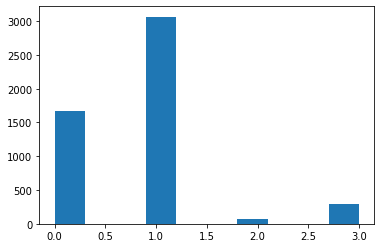

In [165]:
plt.figure()
plt.hist(Y)
plt.show()

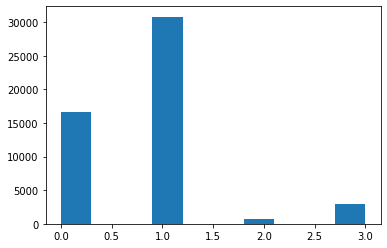

In [166]:
plt.figure()
plt.hist(lab)
plt.show()

In [192]:
np.argwhere(Y==2)

tensor([[3497, 3498, 3499, 3500, 3539, 3540, 3541, 3542, 3580, 3581, 3582, 3583,
         3613, 3614, 3615, 3616, 3658, 3659, 3660, 3696, 3697, 3698, 3741, 3742,
         3743, 3773, 3774, 3775, 3776, 3802, 3803, 3804, 3822, 3823, 3824, 3825,
         3850, 3851, 3852, 3853, 3870, 3871, 3872, 3873, 3886, 3887, 3888, 3909,
         3910, 3911, 3912, 3926, 3927, 3928, 3929, 3944, 3945, 3946, 3947, 3968,
         3969, 3970, 3989, 3990, 3991, 3992, 4011, 4012, 4013, 4014, 4034, 4035,
         4036, 4054, 4055, 4056]])

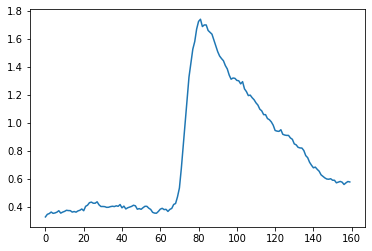

In [198]:
plt.figure()
plt.plot(X[3500,:])
plt.show()

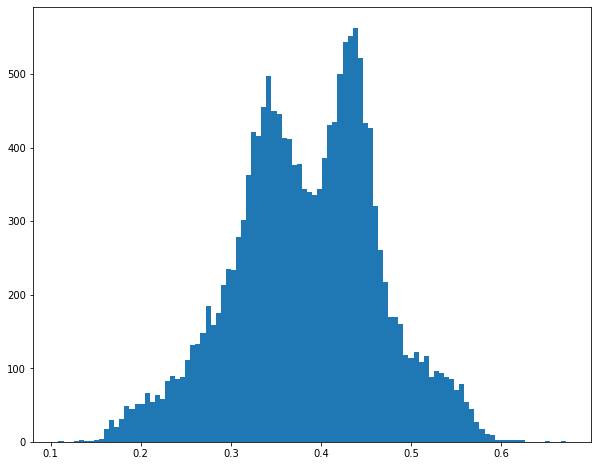

In [187]:
plt.figure(figsize=(10,8))
plt.hist(x[lab==0], bins=100)
plt.show()

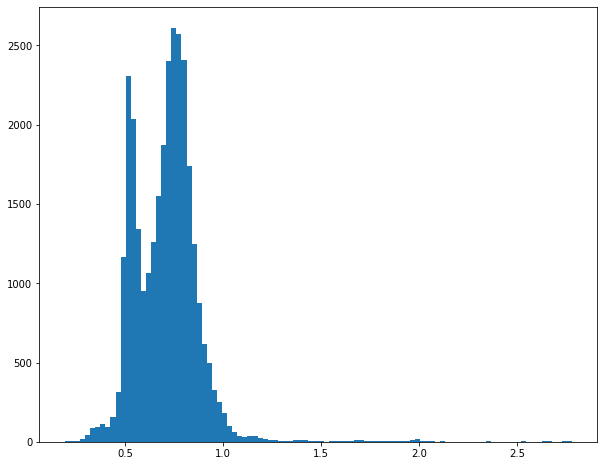

In [188]:
plt.figure(figsize=(10,8))
plt.hist(x[lab==1], bins=100)
plt.show()

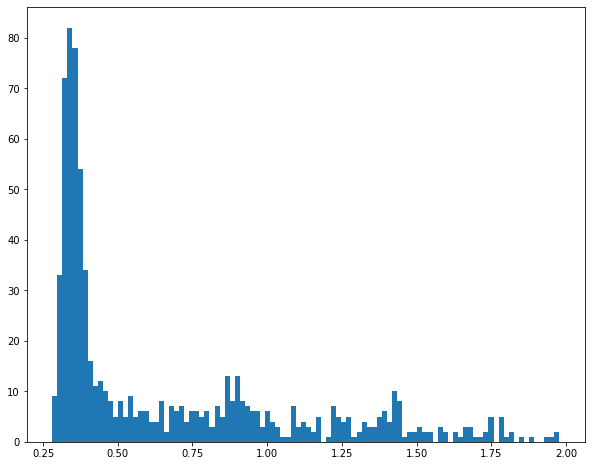

In [189]:
plt.figure(figsize=(10,8))
plt.hist(x[lab==2], bins=100)
plt.show()

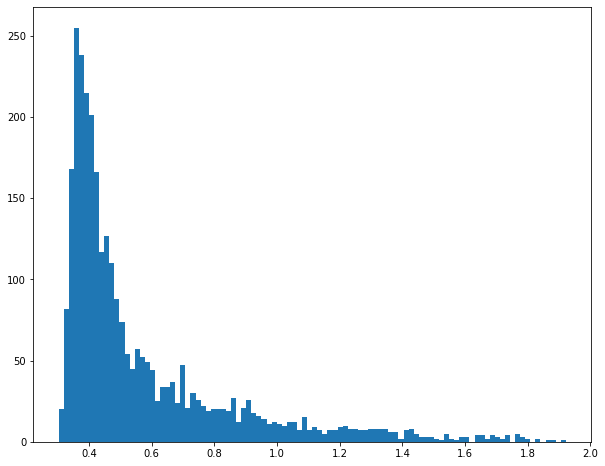

In [190]:
plt.figure(figsize=(10,8))
plt.hist(x[lab==3], bins=100)
plt.show()

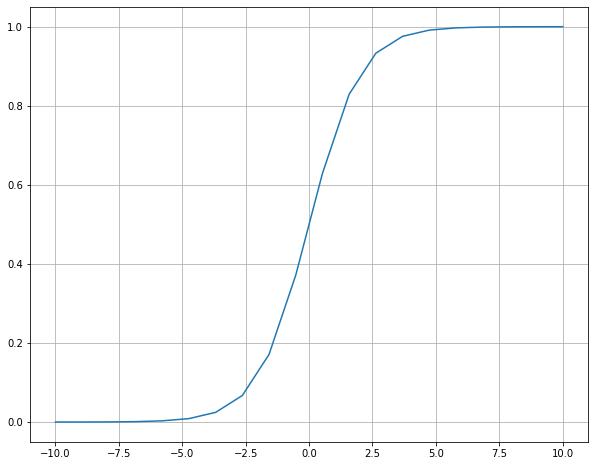

In [231]:
temp = np.linspace(-10,10,20)
plt.figure(figsize=(10,8))
plt.plot(temp,torch.sigmoid(torch.tensor(temp)))
plt.grid(True)
plt.show()

In [232]:
import scipy.signal as sig
import scipy.stats as stat

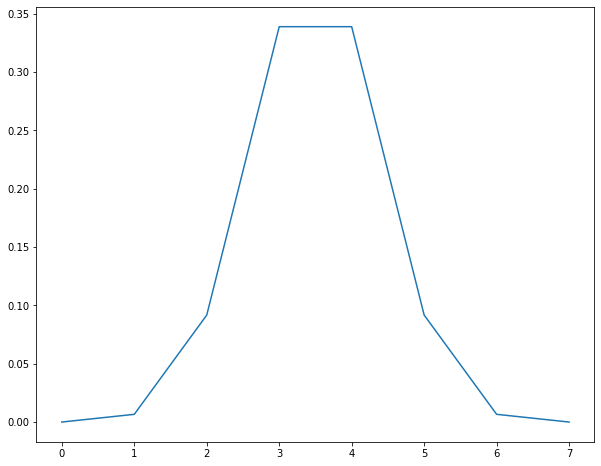

In [254]:
temp = np.linspace(-4,4,8)
n = stat.norm.pdf(temp)
plt.figure(figsize=(10,8))
plt.plot(n)
plt.show()

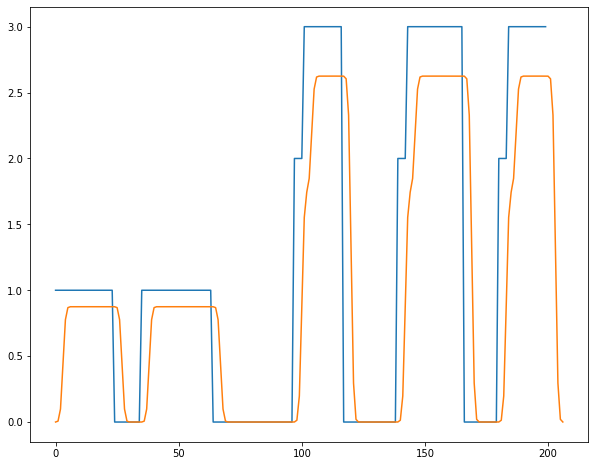

In [255]:
plt.figure(figsize=(10,8))
plt.plot(Y[3400:3600])
plt.plot(sig.convolve(Y[3400:3600], n))
plt.show()

In [279]:
temp = np.zeros(shape=(5,160))
temp

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [280]:
temp.shape

(5, 160)

In [281]:
X.shape

torch.Size([5105, 160])

In [287]:
torch.cat((torch.tensor(temp), X), axis=0).shape

torch.Size([5110, 160])

In [17]:
from scipy.signal import savgol_filter

In [25]:
Y = (tl==2).astype(int)

In [26]:
Y

array([0, 0, 0, ..., 0, 0, 0])

In [27]:
YY = savgol_filter(Y, 11, 2)

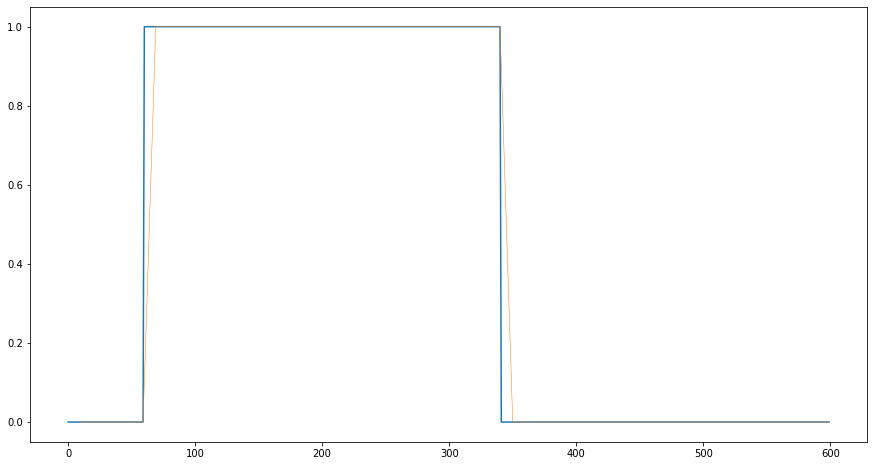

In [42]:
plt.figure(figsize=(15,8))
plt.plot(Y[156900:157500])
#plt.plot(YY[156500:160000], lw=0.5) SGF
plt.plot(pd.Series(Y[156900:157500]).rolling(10).mean(), lw=0.5)
plt.show()